In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df = df.dropna(subset=["CustomerID"])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.duplicated().sum()

5225

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
df.loc[(df.Quantity > 0) & (df.UnitPrice > 0)].describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [11]:
df = df.loc[(df.Quantity > 0) & (df.UnitPrice > 0)]
df.shape

(392692, 8)

In [12]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df =(df.assign(InvoiceMonth=df["InvoiceDate"].map(get_month)))
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [13]:
def get_month_int(df_, column):
    year = df_[column].dt.year
    month = df_[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_month_int(df, "InvoiceMonth")
cohort_year, cohort_month, _ = get_month_int(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = year_diff * 12 + month_diff + 1

In [14]:
# count monthly active customers from each cohort
cohort_data = (df
               .groupby(["CohortMonth", "CohortIndex"])
               ["CustomerID"]
               .apply(pd.Series.nunique)
               )
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index="CohortMonth", columns="CohortIndex",
                  values="CustomerID")
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.div(cohort_size, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


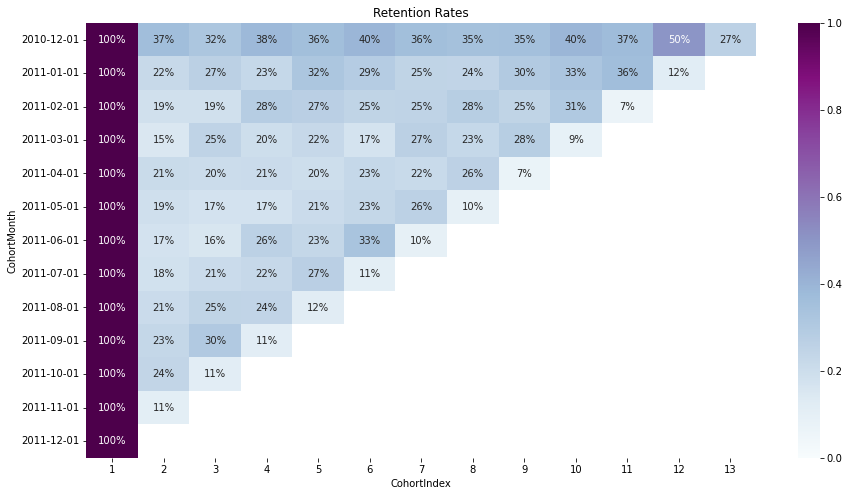

In [16]:
retention.index = retention.index.astype(str)
plt.figure(figsize=(15, 8))
sns.heatmap(data=retention, annot=True, fmt=".0%", vmin=0, vmax=1,
            cmap="BuPu")
plt.title("Retention Rates")
plt.show()

In [17]:
# average quantity for each cohort
cohort_data = (df
              .groupby(["CohortMonth", "CohortIndex"])
              ["Quantity"]
              .mean()
              .reset_index()
              )
average_quantity = (cohort_data
                   .pivot(index="CohortMonth", columns="CohortIndex",
                          values="Quantity")
                   )
average_quantity.round(2)
average_quantity.index = average_quantity.index.date

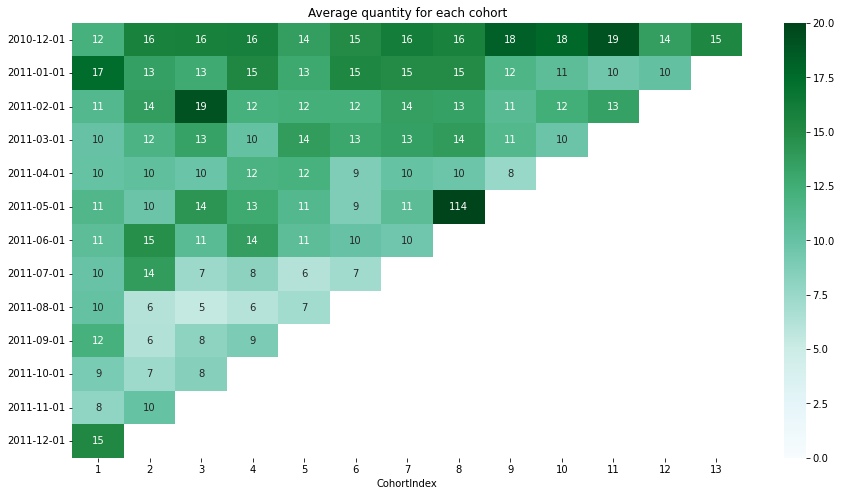

In [18]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=average_quantity, annot=True, vmin=0, vmax=20,
            cmap="BuGn", fmt=".0f")
plt.title("Average quantity for each cohort")
plt.show()

### Recency, Frequency and Monetary Value calculation

#### What is RFM?
- RFM is an acronym of recency, frequency and monetary. Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.


- Frequency is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.


- Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.

<img src="http://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png">

#### The RFM values can be grouped in several ways:

1.Percentiles e.g. quantiles

2.Pareto 80/20 cut

3.Custom - based on business knowledge

We are going to implement percentile-based grouping.

#### Process of calculating percentiles:
- Sort customers based on that metric
- Break customers into a pre-defined number of groups of equal size
- Assign a label to each group

In [23]:
df["TotalSum"] = df["UnitPrice"] * df["Quantity"]

print("Min Invoice Date:", df.InvoiceDate.dt.date.min())
print("Max Invoice Date:", df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01
Max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00


In [26]:
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [32]:
rfm = (df
    .groupby(["CustomerID"]).agg({"InvoiceDate":
                                  lambda x: (snapshot_date - x.max()).days,
                                  "InvoiceNo": "count",
                                  "TotalSum": "sum"})
       )

rfm =rfm.rename(columns={"InvoiceDate":"Recency",
                    "InvoiceNo":"Frequency",
                    "TotalSum":"MonetaryValue"})

rfm.head()

# Recency -> lower is a better customer, purchase recently
# Frequency & MonetaryValue -> higher is a better

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [57]:
# Building RFM segments
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(rfm["Recency"], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm["Frequency"], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm["MonetaryValue"], q=4, labels=m_labels)

rfm = rfm.assign(R=r_quartiles,
                 F=f_quartiles,
                 M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(df):
    return df["R"].astype(str) + df["F"].astype(str) + df["M"].astype(str)

rfm["RFM_Segment"] = rfm.pipe(add_rfm)
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


In [59]:
# Analyzing RFM Segments
# Largest RFM segments It is always the best practice to investigate the size of the segments 
# before you use them for targeting or other business Application.

(rfm
    .groupby(["RFM_Segment"])
    .size()
    .sort_values(ascending=False)
    [ :5])

RFM_Segment
444    450
111    381
344    217
122    206
211    179
dtype: int64

In [62]:
# Filtering on RFM segments
# Select bottom RFM segment "111" and view top 10 rows

rfm.loc[rfm["RFM_Segment"] == "111"].sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,4,89.00,1,1,1,111,3
17881.0,304,8,133.35,1,1,1,111,3
13482.0,232,11,184.64,1,1,1,111,3
14241.0,184,10,213.70,1,1,1,111,3
16471.0,275,13,223.95,1,1,1,111,3
12736.0,333,4,234.00,1,1,1,111,3
13382.0,281,15,222.99,1,1,1,111,3
14689.0,209,13,112.80,1,1,1,111,3
12574.0,316,11,218.45,1,1,1,111,3


In [77]:
# Summary metrics per RFM Score

(rfm
    .groupby("RFM_Score")
    .agg({"Recency":"mean", "Frequency":"mean",
          "MonetaryValue":["mean", "count"]})
    .round(1)
)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

In [81]:
# Use RFM score to group customers into Gold, Silver and Bronze segments

def segments(df):
    if df["RFM_Score"] > 9:
        return "Gold"
    elif (df["RFM_Score"] > 5) & (df["RFM_Score"] <= 9):
        return "Silver"
    else:
        return "Bronze"

rfm["General_Segment"] = rfm.apply(segments, axis=1)

(rfm
    .groupby("General_Segment")
    .agg({"Recency":"mean",
          "Frequency":"mean",
          "MonetaryValue":["mean", "count"]})
    .round(1)
)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Silver             72.0      49.4        1072.4  1788

### Data Preprocessing for Kmeans Clustering

must check these assumptions before we implement our Kmeans Clustering Mode

- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

In [87]:
rfm.loc[:, ["Recency", "Frequency", "MonetaryValue"]].describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


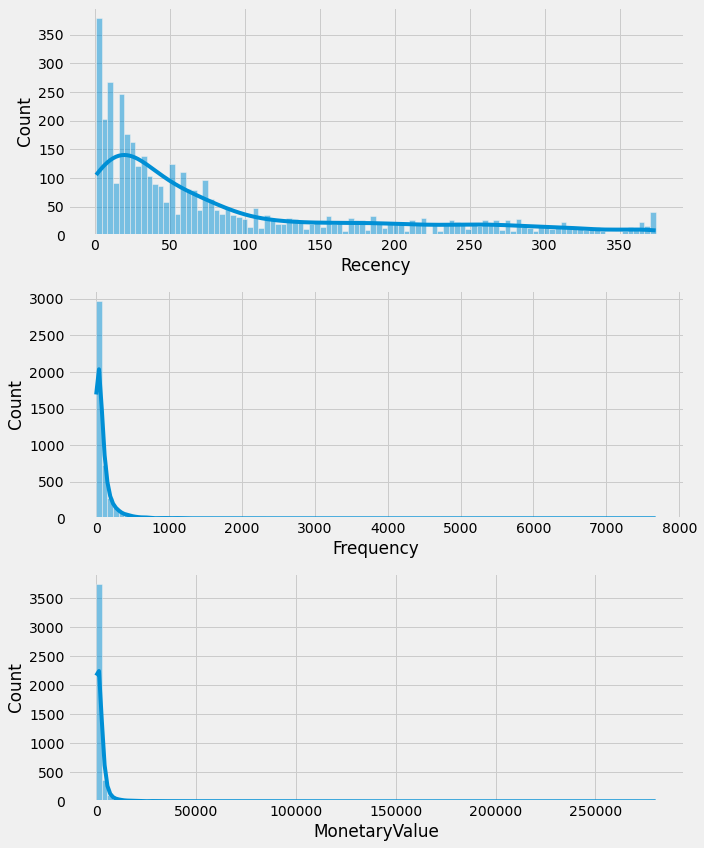

In [103]:
# plot the distribution of RFM values
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10, 12))
axes = axes.flatten()
sns.histplot(rfm["Recency"], ax=axes[0], kde=True, bins=100)
sns.histplot(rfm["Frequency"], ax=axes[1], kde=True, bins=100)
sns.histplot(rfm["MonetaryValue"], ax=axes[2], kde=True, bins=100)
plt.style.use("fivethirtyeight")
plt.tight_layout()
plt.show()

In [108]:
rfm_log = (rfm.loc[:, ["Recency", "Frequency", "MonetaryValue"]]
           .apply(np.log, axis=1)
           .round(3)
          )
rfm_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,5.787,0.000,11.254
12347.0,0.693,5.204,8.369
12348.0,4.317,3.434,7.494
12349.0,2.944,4.290,7.472
12350.0,5.737,2.833,5.812


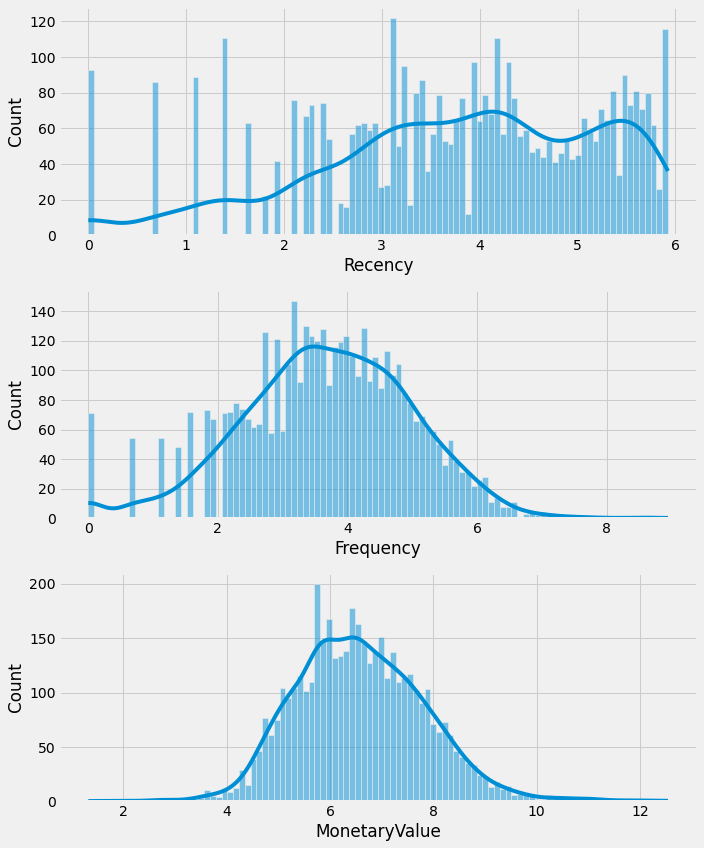

In [109]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10, 12))
axes = axes.flatten()
sns.histplot(rfm_log["Recency"], ax=axes[0], kde=True, bins=100)
sns.histplot(rfm_log["Frequency"], ax=axes[1], kde=True, bins=100)
sns.histplot(rfm_log["MonetaryValue"], ax=axes[2], kde=True, bins=100)
plt.style.use("fivethirtyeight")
plt.tight_layout()
plt.show()

### Implementation of K-Means Clustering

Key steps

1. Data pre-processing
2. Choosing a number of clusters
3. Running k-means clustering on pre-processed data
4. Analyzing average RFM values of each cluster

In [110]:
from sklearn.preprocessing import StandardScaler

# Normalize the variables with standardscaler
scaler = StandardScaler()
scaler.fit(rfm_log)
rfm_normalized = scaler.transform(rfm_log)

Methods to define the number of clusters

- Visual methods - elbow criterion
- Mathematical methods - silhouette coefficient
- Experimentation and interpretation

Elbow criterion method

- Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
- Identify an "elbow" in the plot
- Elbow - a point representing an "optimal" number of clusters

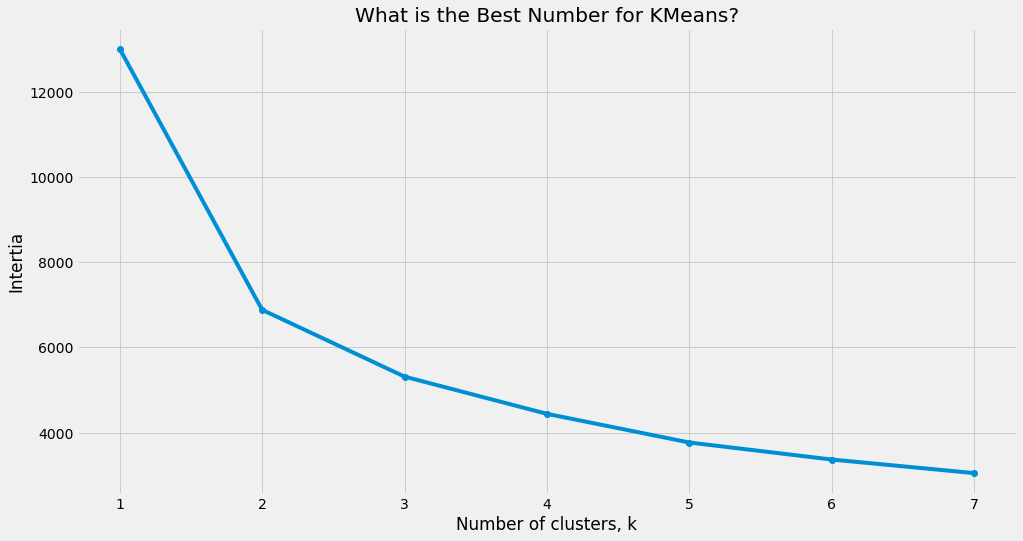

In [122]:
from sklearn.cluster import KMeans

# First : Get the Best KMeans
ks = range(1, 8)
inertias = []
for k in ks:
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, "-o")
plt.xlabel("Number of clusters, k")
plt.ylabel("Intertia")
plt.xticks(ks)
plt.title("What is the Best Number for KMeans?")
plt.show()

In [126]:
# clustering
kc = KMeans(n_clusters=3, random_state=1)
kc.fit(rfm_normalized)

# Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

# Calculate average RFM values and size for each cluster
rfm_k3 = rfm.assign(K_Cluster=cluster_labels)

(rfm_k3
     .groupby("K_Cluster")
     .agg({"Recency":"mean",
           "Frequency":"mean",
           "MonetaryValue":["mean", "count"]})
     .round(0)
)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0           171.0      15.0         293.0  1523
1            69.0      65.0        1167.0  1859
2            13.0     260.0        6559.0   956